# Task 1 - Text classification

Text is a type of unstructure data. Machine Learning algorithms do not work well with any type of variable different from numbers, and text is all but numbers. Recently, in the NLP field, most of the new discoveries have been made thanks to defining new Deep Learning architectures to generate high quality word embeddings. They are a set of feature vector representations where words from a vocabulary are mapped to vector of real numbers. It all started in 2013 when Mikolov et. al. first introduced the Skip-gram model [1]. From Word2vec, several new model were developed such as ELMo [2] and BERT [3], the actual state-of-the-art model, among others.

After a bit of background, the idea to solve this task is to use BERT or Universal Sentence Encoder (USE) [4] to encode the documents into vectors that can be feed into a Machine Learning classifier. Moreover, we need a model that understand, at least, our 3 languages. Then, we need a multilingual model.

From the exploratory analysis, we recommend to use a pretrained model. There are plenty of them in Tensorflow Hub, in particular, Multilingual BERT and Multilingual USE [5] are available. Because MUSE does not required preprocessing, as the input data does not need to be masked, we are going to use it first. That is the reason why this task is divided in two jupyter notebooks, one in Google colab (**MUSE- Word Embeddings**)to create the word embeddings because MUSE uses a library (tensorflow_text) that does not work in windows, and the second one is this notebook run locally. 

### 1) Load libraries

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import sys
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics

### 2) Read the csv

This csv is the output from the notebook run in Google Colab.

The word embedding is flatten, generating as many columns as the length of the vector (512).

In [86]:
df_f= pd.read_csv('ea_embeddings_muse_flatten.csv', sep=',', header=0)

In [87]:
df_f.head()

,language,category,2,3,4,5,6,7,8,9,...,504,505,506,507,508,509,510,511,512,513
0,en,APR,-0.019496,0.028128,-0.011202,0.040384,-0.076767,0.066849,0.036627,-0.000093,...,-0.043784,-0.007727,0.005836,-0.046863,-0.003643,0.009728,-0.000819,-0.073423,0.030665,0.023028
1,en,APR,-0.002822,-0.045204,-0.016848,0.053938,0.039466,0.065693,-0.025186,-0.028859,...,0.048659,0.073567,-0.085638,-0.064839,-0.070530,-0.083139,0.011784,-0.018194,0.042321,0.045972
2,en,APR,0.026813,-0.011513,-0.018855,0.043837,0.051915,0.044183,-0.004949,-0.061447,...,0.032723,-0.029836,-0.032390,-0.014507,-0.048853,-0.016512,0.011402,-0.006926,0.050542,0.072263
3,en,APR,-0.054095,0.026708,-0.001139,0.000139,-0.019378,0.063965,0.024880,0.032522,...,0.045528,-0.062564,0.006448,-0.019202,-0.047049,-0.063975,-0.059755,-0.069993,0.065400,-0.015806
4,en,APR,0.044433,0.037699,-0.054426,-0.018390,-0.046270,0.053568,0.022592,-0.059755,...,0.045455,0.008011,-0.014587,0.044229,0.035727,0.030701,0.032198,-0.065506,0.039980,0.059288


One hot encoding of categorical variables.

In [88]:
# use pd.concat to join the new columns with your original dataframe
df_f = pd.concat([df_f,pd.get_dummies(df_f['language'], prefix='language')],axis=1)

# now drop the original 'country' column (you don't need it anymore)
df_f.drop(['language'],axis=1, inplace=True)

In [89]:
df_f.head()

,category,2,3,4,5,6,7,8,9,10,...,507,508,509,510,511,512,513,language_en,language_es,language_fr
0,APR,-0.019496,0.028128,-0.011202,0.040384,-0.076767,0.066849,0.036627,-0.000093,-0.061016,...,-0.046863,-0.003643,0.009728,-0.000819,-0.073423,0.030665,0.023028,1,0,0
1,APR,-0.002822,-0.045204,-0.016848,0.053938,0.039466,0.065693,-0.025186,-0.028859,0.004115,...,-0.064839,-0.070530,-0.083139,0.011784,-0.018194,0.042321,0.045972,1,0,0
2,APR,0.026813,-0.011513,-0.018855,0.043837,0.051915,0.044183,-0.004949,-0.061447,-0.014167,...,-0.014507,-0.048853,-0.016512,0.011402,-0.006926,0.050542,0.072263,1,0,0
3,APR,-0.054095,0.026708,-0.001139,0.000139,-0.019378,0.063965,0.024880,0.032522,-0.010525,...,-0.019202,-0.047049,-0.063975,-0.059755,-0.069993,0.065400,-0.015806,1,0,0
4,APR,0.044433,0.037699,-0.054426,-0.018390,-0.046270,0.053568,0.022592,-0.059755,0.066712,...,0.044229,0.035727,0.030701,0.032198,-0.065506,0.039980,0.059288,1,0,0


We separate the feature vector and the label in two different dataframes.

In [91]:
df_label = df_f['category']
df_features = df_f.drop(columns=['category'])

We split the dataset into training (80%) and test (20%). With the stratify function, it is ensure that there is a good proportion of the 4 labels in both sets.

In [92]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_label, stratify=df_label, test_size=0.2)

We train a classifier an we are going to start with a very basic as Logistic Regression model, because sometimes the simpler the better. There are also other reasons for that, for example, not all the languages have text in all categories, so it is easy to discard a language in some categories, reducing the problem to a kind of "binary" classification.

In [99]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
score = lr.score(X_test, y_test)
print(score)

cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

print(metrics.classification_report(y_test, y_pred))

0.9929906542056075
[[1274    1    3    4]
 [   0  121    0    3]
 [  11    1  565    7]
 [   0    0    3 2715]]
                   precision    recall  f1-score   support

              APR       0.99      0.99      0.99      1282
Conference_papers       0.98      0.98      0.98       124
            PAN11       0.99      0.97      0.98       584
        Wikipedia       0.99      1.00      1.00      2718

         accuracy                           0.99      4708
        macro avg       0.99      0.98      0.99      4708
     weighted avg       0.99      0.99      0.99      4708



In [104]:
print(y_test[0:10])
print(y_pred[0:10])

14505    Wikipedia
13514    Wikipedia
7682         PAN11
11380    Wikipedia
21078    Wikipedia
1639           APR
10915    Wikipedia
7446         PAN11
23407    Wikipedia
4981           APR
Name: category, dtype: object
['Wikipedia' 'Wikipedia' 'PAN11' 'Wikipedia' 'Wikipedia' 'APR' 'Wikipedia'
 'PAN11' 'Wikipedia' 'APR']


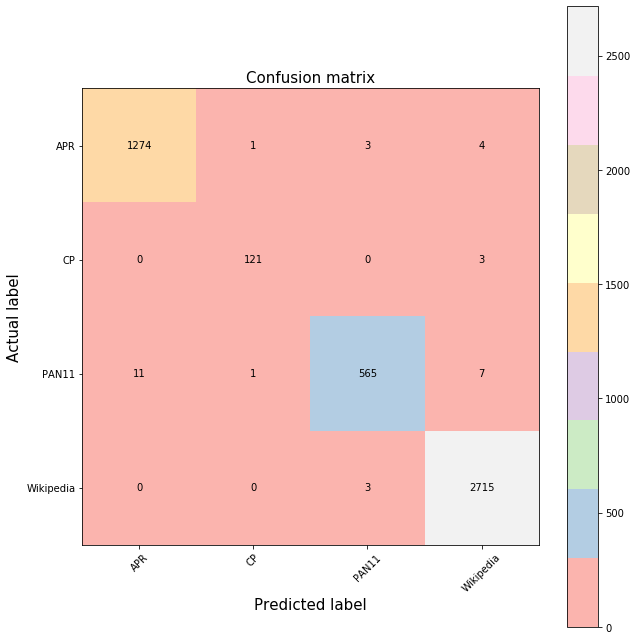

In [102]:
plt.figure(figsize=(9,9))
plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion matrix', size = 15)
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, ["APR", "CP", "PAN11", "Wikipedia"], rotation=45, size = 10)
plt.yticks(tick_marks, ["APR", "CP", "PAN11", "Wikipedia"], size = 10)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), 
        horizontalalignment='center',
        verticalalignment='center')

The resuts are impressively good, even we could consider that the model is overfitted. It classifies correctly almost all the instances, keeping the proportion within categories, even with Conference_papers that are not too many. 

It is not needed to try to generate a model with a more complex classifier, but it is interesting to try to reduce the accuracy in order to have a more general classifier.

### 4) Trying to reduce the overfitting

We are going to get the average of each embedding to reduce the amount of specific information from each task, trying to reduce the almost perfect classification from the former training.

In [54]:
df = pd.read_csv('ea_embeddings_muse_mean.csv', sep=',', header=0)

In [55]:
df.head()

,text,category,language,embeddings_numpy,embeddings_mean
0,"i read this book because in my town, everyone ...",APR,en,[-1.94959100e-02 2.81282254e-02 -1.12017877e-...,0.002181
1,recipes appreciated by the family (small and l...,APR,en,[-0.00282194 -0.04520444 -0.01684837 0.053938...,-0.002749
2,i say no to ease ..... and not to the author w...,APR,en,[ 2.68126614e-02 -1.15128653e-02 -1.88549645e-...,0.001731
3,milady has found a good vein: anita blake. bas...,APR,en,[-0.05409476 0.02670753 -0.00113879 0.000138...,-0.000196
4,"460 bc, somewhere in greece: ""gentlemen, i dec...",APR,en,[ 0.04443264 0.03769898 -0.05442553 -0.018389...,0.000865


In [56]:
# use pd.concat to join the new columns with your original dataframe
df = pd.concat([df,pd.get_dummies(df['language'], prefix='language')],axis=1)

# now drop the original 'country' column (you don't need it anymore)
df.drop(['language'],axis=1, inplace=True)

In [57]:
df.head()

,text,category,embeddings_numpy,embeddings_mean,language_en,language_es,language_fr
0,"i read this book because in my town, everyone ...",APR,[-1.94959100e-02 2.81282254e-02 -1.12017877e-...,0.002181,1,0,0
1,recipes appreciated by the family (small and l...,APR,[-0.00282194 -0.04520444 -0.01684837 0.053938...,-0.002749,1,0,0
2,i say no to ease ..... and not to the author w...,APR,[ 2.68126614e-02 -1.15128653e-02 -1.88549645e-...,0.001731,1,0,0
3,milady has found a good vein: anita blake. bas...,APR,[-0.05409476 0.02670753 -0.00113879 0.000138...,-0.000196,1,0,0
4,"460 bc, somewhere in greece: ""gentlemen, i dec...",APR,[ 0.04443264 0.03769898 -0.05442553 -0.018389...,0.000865,1,0,0


In [58]:
df = df.drop(columns=['text','embeddings_numpy'])
df_label = df['category']
df_features = df.drop(columns=['category'])

In [59]:
df_features.head()

,embeddings_mean,language_en,language_es,language_fr
0,0.002181,1,0,0
1,-0.002749,1,0,0
2,0.001731,1,0,0
3,-0.000196,1,0,0
4,0.000865,1,0,0


In [60]:
df_label.head()

0    APR
1    APR
2    APR
3    APR
4    APR
Name: category, dtype: object

In [61]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_label, stratify=df_label, test_size=0.2)

In [82]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
score = lr.score(X_test, y_test)
print(score)

cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

print(metrics.classification_report(y_test, y_pred))

0.5800764655904843
[[  60    0    0 1222]
 [  38    0    0   86]
 [  18    0    0  566]
 [  47    0    0 2671]]
                   precision    recall  f1-score   support

              APR       0.37      0.05      0.08      1282
Conference_papers       0.00      0.00      0.00       124
            PAN11       0.00      0.00      0.00       584
        Wikipedia       0.59      0.98      0.74      2718

         accuracy                           0.58      4708
        macro avg       0.24      0.26      0.20      4708
     weighted avg       0.44      0.58      0.45      4708



D:\Anaconda\envs\tf2_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Anaconda\envs\tf2_gpu\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The results using the mean of the embedding are way worse. The classifier tends to identify only the most predominant category. The accuracy metrics and confusion matrix are not good, hence this model is discard and we keep using the former one.

## References

* [1] T. Mikolov, K. Chen, G. Corrado, and J. Dean, “Efficient estimation ofword representations in vector space,”Proceedings of Workshop at ICLR,vol. 2013, January 2013
* [2] M. E. Peters, M. Neumann, M. Iyyer, M. Gardner, C. Clark, K. Lee, andL. Zettlemoyer, “Deep contextualized word representations,” 2018.
* [3] J. Devlin, M.-W. Chang, K. Lee, and K. Toutanova, “Bert: Pre-trainingof deep bidirectional transformers for language understanding,” 2018.
* [4] Yinfei Yang, Daniel Cer, Amin Ahmad, Mandy Guo, Jax Law, Noah Constant, Gustavo Hernandez Abrego , Steve Yuan, Chris Tar, Yun-hsuan Sung, Ray Kurzweil. Multilingual Universal Sentence Encoder for Semantic Retrieval. July 2019
* [5] Muthuraman Chidambaram, Yinfei Yang, Daniel Cer, Steve Yuan, Yun-Hsuan Sung, Brian Strope, Ray Kurzweil. Learning Cross-Lingual Sentence Representations via a Multi-task Dual-Encoder Model. To appear, Repl4NLP@ACL, July 2019.